# Climate Modelling Project - 2D Graphics

---------------

## 0. Import Libraries

In [32]:
from datetime import datetime

import cartopy
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot
import requests
import rioxarray
import xarray as xr
from bs4 import BeautifulSoup
from matplotlib.colors import BoundaryNorm
from scipy.constants import g
from shapely.geometry import mapping
from visjobs.datas import get_ERA5

from functions import *
from visualization_codes import plot_facet_map

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------

## 1. Open Data

#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

In [2]:
# Parameters to change ------------
is_single = True # if single level: True ; if pressure level: False
model_var = 'TOT_PREC'   # possible for single: PMSL, RELHUM_2M, TOT_PREC, T_2M, U_10M, V_10M
                     # possible for pressure: FI, RELHUM, T
era5_var = 'tp' # possible for single: 2t, msl, 10u, 10v
                # possible for pressure: t, z
year = '2013'
model_level = 'sfc' # sfc or pl
plevel = 100000 # in Pa (if using model_level=sfc, this must be 100000 (one hundred thousand Pa))
start_month = 1 # january
end_month = 12 # december

# ----------------

path = r'Data/'
single = 'Merged_New_Single.nc'
pressure = 'Merged_New_Pressure.nc'
    
#################### era5 data (remotely)
# var names
var_map_dict =  define_era5_var_matching_name()
# credentials
username, password = define_credentials()

# get data link
data_link = retrieve_era5_data_link(model_level, era5_var, year)

# start session
session = session_accredition(username, password)

#access authorization
store = xr.backends.PydapDataStore.open(data_link,
                                        session=session)
#get data
era5_dt = xr.open_dataset(store)

#################### model data (and also clip era5 data)
if is_single:

    dt = xr.open_dataset(path + single).sel(time = year)[model_var]
    
    # clip to nearest borders
    era5_dt = era5_dt.sel(longitude = slice(15, 40), 
                          latitude = slice(50, 30), 
                          )[var_map_dict[era5_var]]

else:

    dt = xr.open_dataset(path + pressure).sel(time = year, pressure=plevel)[model_var]
    
    # clip to nearest borders
    era5_dt = era5_dt.sel(longitude = slice(15, 40), 
                          latitude = slice(50, 30), 
                          level=plevel/100)[var_map_dict[era5_var]]

/mnt/c/Users/USER/JupyterLab/Portfolio/ClimateModelling/ClimateModellingLesson/functions.py:148: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 148 of the file /mnt/c/Users/USER/JupyterLab/Portfolio/ClimateModelling/ClimateModellingLesson/functions.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(page.content)


In [3]:
dt

<xarray.DataArray 'TOT_PREC' (time: 1460, rlat: 48, rlon: 62)>
[4344960 values with dtype=float32]
Coordinates:
    lat      (rlat, rlon) float32 ...
    lon      (rlat, rlon) float32 ...
  * rlat     (rlat) float32 -3.16 -2.94 -2.72 -2.5 -2.28 ... 6.52 6.74 6.96 7.18
  * rlon     (rlon) float32 -8.78 -8.56 -8.34 -8.12 -7.9 ... 3.98 4.2 4.42 4.64
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Attributes:
    standard_name:  precipitation_amount
    long_name:      total precipitation amount
    units:          kg m-2
    grid_mapping:   rotated_pole
    cell_methods:   time: sum

In [4]:
era5_dt

<xarray.DataArray 'TP' (time: 12, latitude: 81, longitude: 101)>
array([[[2.338409e-03, 2.216339e-03, ..., 2.296448e-03, 2.321243e-03],
        [2.737045e-03, 2.616882e-03, ..., 2.401352e-03, 2.437592e-03],
        ...,
        [1.392365e-04, 1.220703e-04, ..., 6.141663e-04, 6.866455e-04],
        [1.277924e-04, 1.068115e-04, ..., 6.523132e-04, 7.152557e-04]],

       [[2.187729e-03, 2.258301e-03, ..., 7.724762e-04, 7.476807e-04],
        [2.288818e-03, 2.347946e-03, ..., 7.495880e-04, 7.305145e-04],
        ...,
        [8.583069e-05, 1.049042e-04, ..., 3.013611e-04, 2.784729e-04],
        [1.049042e-04, 1.144409e-04, ..., 2.803802e-04, 2.040863e-04]],

       ...,

       [[1.279831e-03, 1.337051e-03, ..., 7.896423e-04, 7.534027e-04],
        [1.239777e-03, 1.287460e-03, ..., 8.125305e-04, 7.839203e-04],
        ...,
        [5.149841e-05, 5.340576e-05, ..., 1.171112e-03, 1.020432e-03],
        [2.288818e-05, 2.479553e-05, ..., 1.092911e-03, 1.064301e-03]],

       [[7.305145e-04, 7.266998e-04, ..., 6.198883e-04, 6.408691e-04],
        [8.068085e-04, 8.068085e-04, ..., 7.076263e-04, 7.324219e-04],
        ...,
        [1.506805e-04, 9.918213e-05, ..., 5.683899e-04, 4.177094e-04],
        [1.049042e-04, 8.583069e-05, ..., 4.558563e-04, 3.948212e-04]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 15.0 15.25 15.5 15.75 ... 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2013-12-01
Attributes: (12/15)
    long_name:                     Total precipitation
    short_name:                    tp
    units:                         m
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               228
    ...                            ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface fore...
    number_of_significant_digits:  7
    _ChunkSizes:                   [3, 389, 776]

---------------

## 2. Functions

In [5]:
# Retrieved functions from function.py in the current directory

-----------------------

## 3 Assign Projection Info to Datasets

### 3.1 Model Data

In [6]:
# General data information
crs_parameters = {'pole_longitude': -151.0,
                  'pole_latitude': 53.0,
                  }
crs_data = cartopy.crs.RotatedPole(**crs_parameters).proj4_params
x_dims = 'rlon'
y_dims = 'rlat'

# assign proj info
dt = assing_proj_info(dt, crs_data, x_dims, y_dims)

### 3.2 ERA5 Data

In [7]:
# General data information
crs_data_era5 = 4326
x_dims_era5 = 'longitude'
y_dims_era5 = 'latitude'

# assign proj info
era5_dt = assing_proj_info(era5_dt, crs_data_era5, x_dims_era5, y_dims_era5)

--------

## 4. Monthly Averages

For total precipitation variable, these functions take monthly sum instead of monthly mean.

### 4.1 Model Data

In [8]:
# get average of all months
average_model = get_average(dt, model_var, start_month,
                            end_month, 
                            )            
# get average of each month
average_bymonth_model = get_average_bymonth(dt, model_var, start_month, 
                                            end_month, 
                                            )                 

# assign proj info
average_model = assing_proj_info(average_model, crs_data, x_dims, y_dims)
average_bymonth_model = assing_proj_info(average_bymonth_model, crs_data, x_dims, y_dims)

### 4.2 ERA5 Data

In [16]:
average = get_average(era5_dt, var_map_dict[era5_var],
                      start_month, end_month,
                      )
average_bymonth = get_average_bymonth(era5_dt, var_map_dict[era5_var],
                                      start_month, end_month,
                                      )
    
# assign proj info
average = assing_proj_info(average, crs_data_era5, 
                           x_dims_era5, y_dims_era5)
average_bymonth = assing_proj_info(average_bymonth, crs_data_era5, 
                                   x_dims_era5, y_dims_era5)

---------------

## 5. Reproject ERA5 to Model Data

In [18]:
# average
average_reprojected = average.rio.reproject_match(average_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_reprojected = average_reprojected.assign_coords(dict(
                            lon=(["rlat", "rlon"], average_model['lon'].values),
                            lat=(["rlat", "rlon"], average_model['lat'].values)))

# average by month
average_bymonth_reprojected = average_bymonth.rio.reproject_match(average_bymonth_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_bymonth_reprojected = average_bymonth_reprojected.assign_coords(dict(
                                        lon=(["rlat", "rlon"], average_bymonth_model['lon'].values),
                                        lat=(["rlat", "rlon"], average_bymonth_model['lat'].values)))

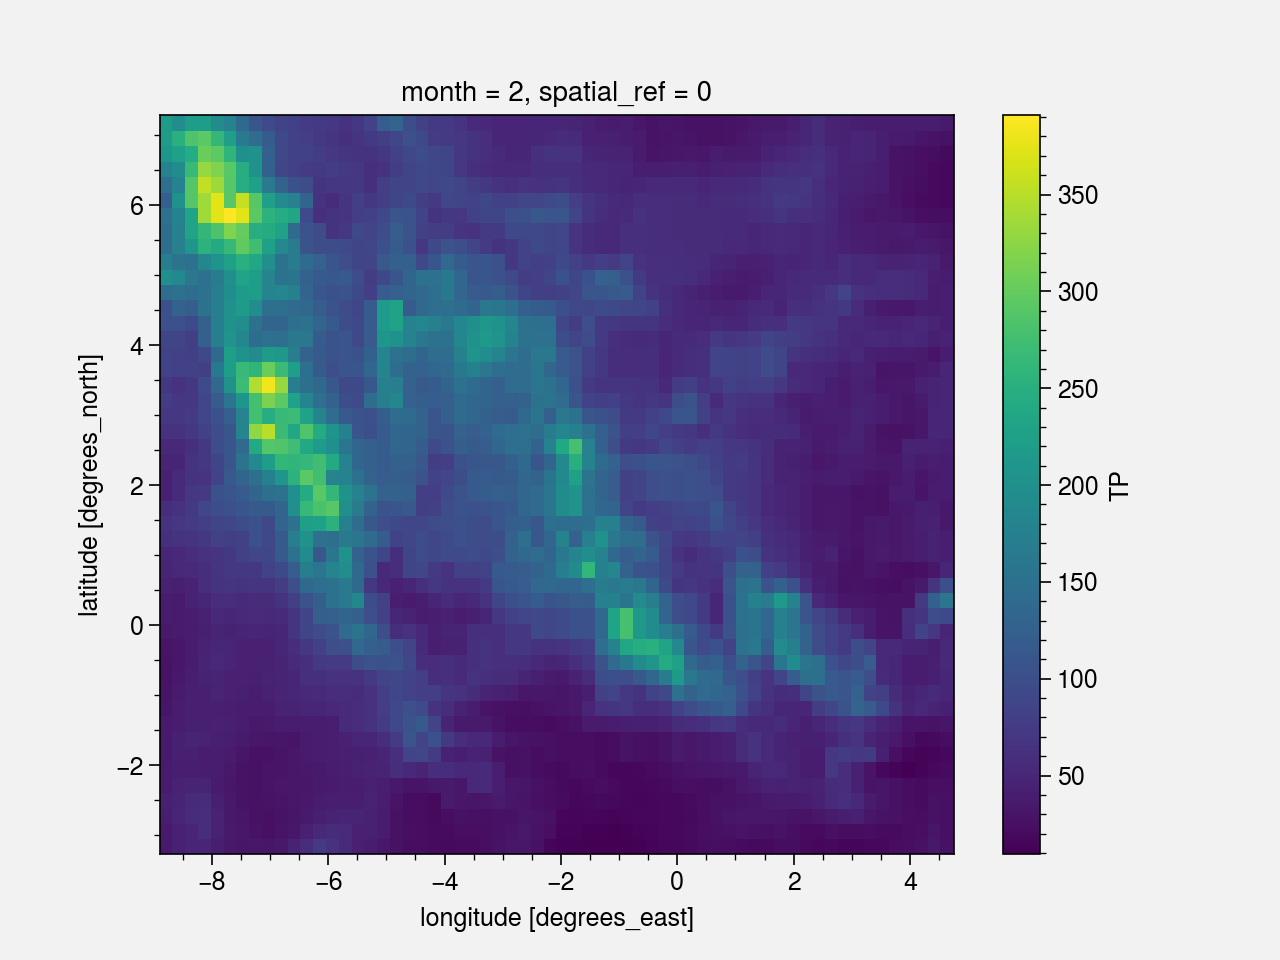

In [19]:
# ERA5 sample image
(average_bymonth_reprojected[1]).plot()

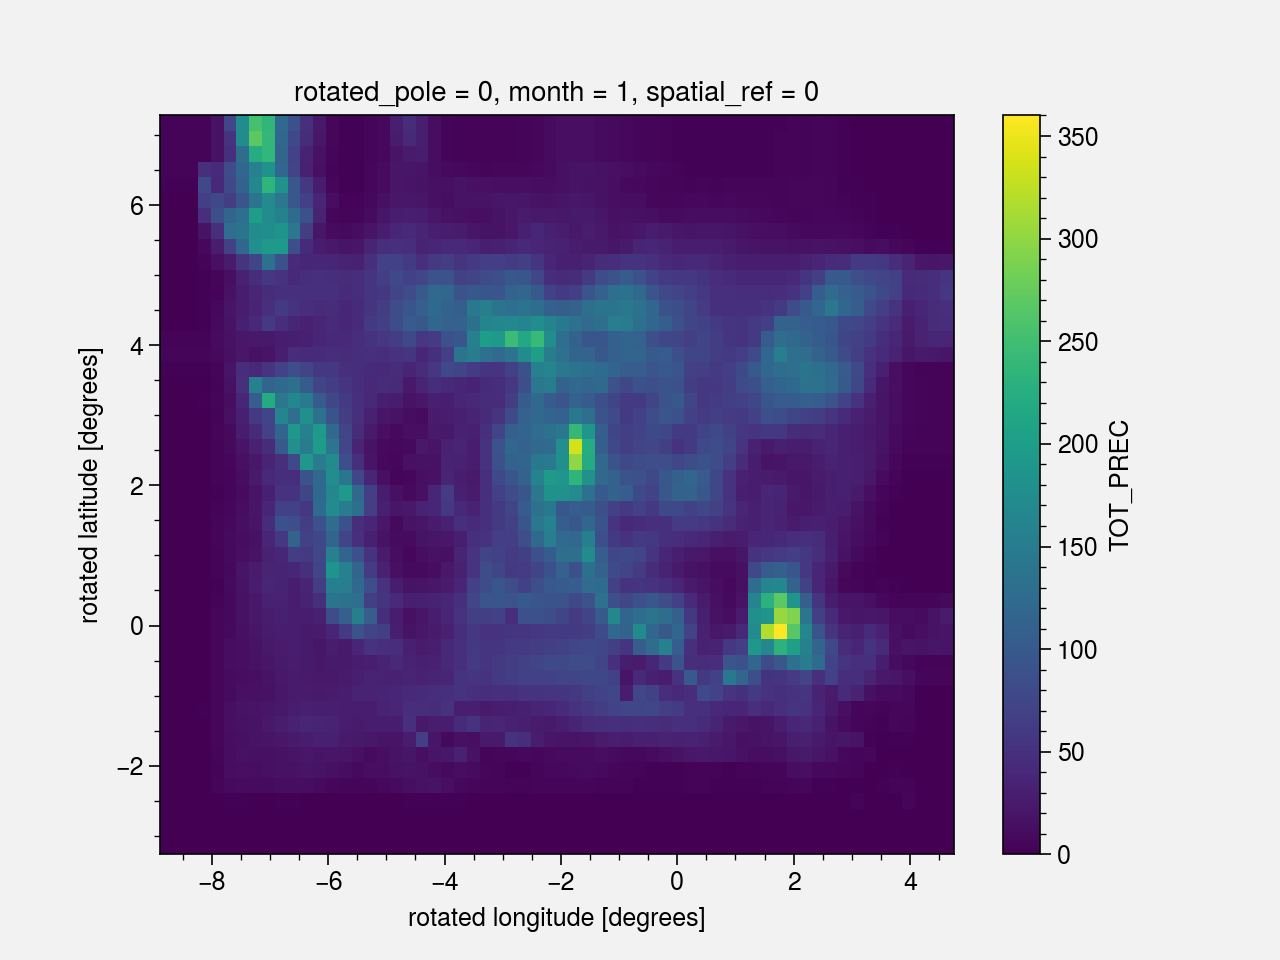

In [20]:
# MODEL sample image
average_bymonth_model[0].plot()

-------------

## 6. Visualization

### 6.1 Interpolate Datasets

In [21]:
rlat, rlon = average_model.indexes.values()

# interpolate whole months averages
average_reprojected_interp = average_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_model_interp = average_model.interp(rlon=rlon, rlat=rlat, method="nearest")

# interpolate one monthly averages
average_bymonth_reprojected_interp = average_bymonth_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_bymonth_model_interp = average_bymonth_model.interp(rlon=rlon, rlat=rlat, method="nearest")

### 6.2 Facet Graphic

In [22]:
average_difference = average_reprojected_interp - average_model_interp

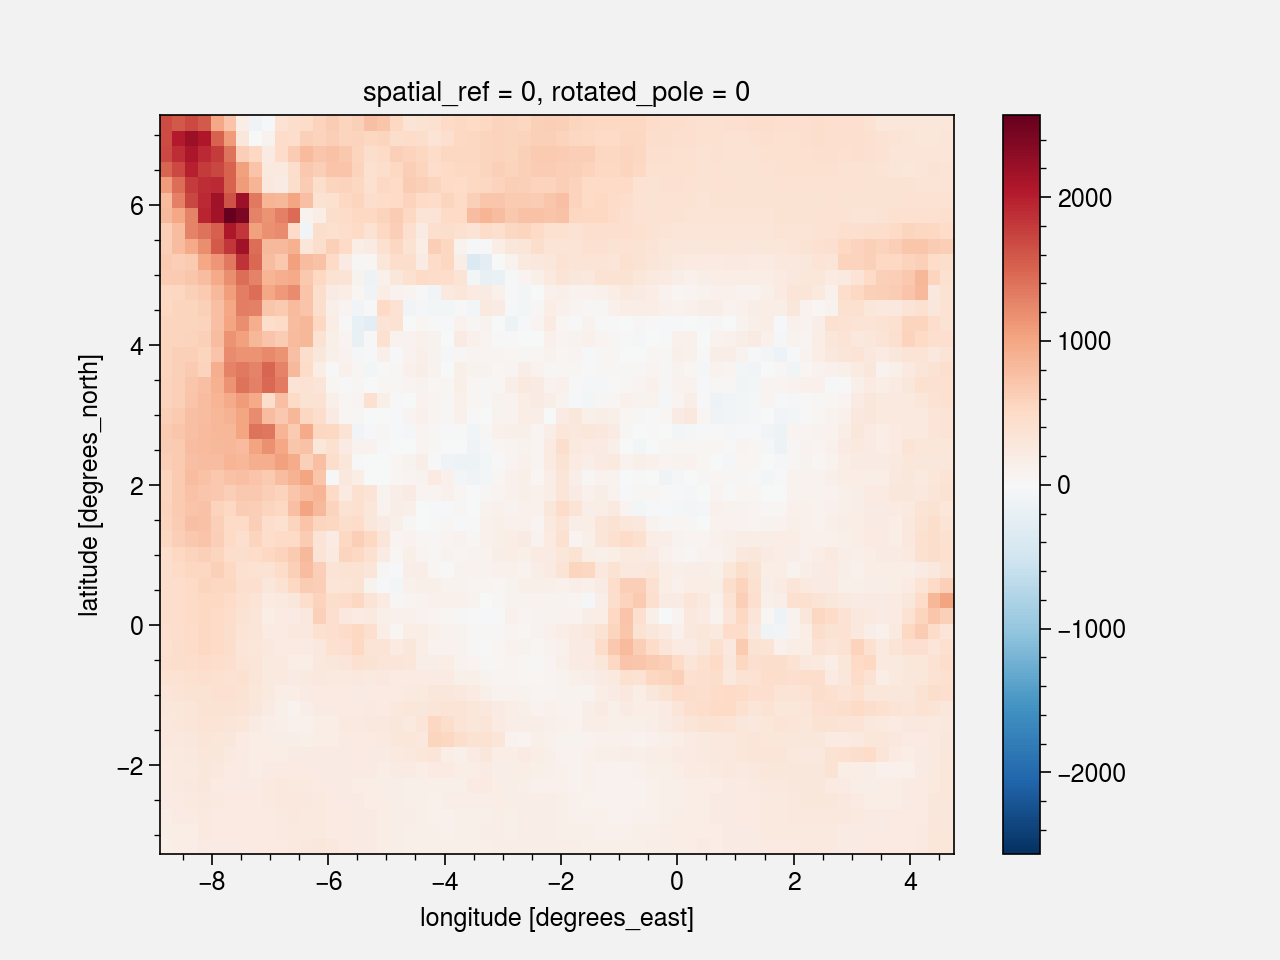

In [23]:
average_difference.plot()

### 6.2.1 Monhtly Mean Graphic

In [24]:
average_bymonth_difference = average_bymonth_reprojected_interp - average_bymonth_model_interp

In [25]:
print(average_bymonth_difference.min())
print(average_bymonth_difference.max())

<xarray.DataArray ()>
array(-246.51745605)
Coordinates:
    spatial_ref   int64 0
    rotated_pole  int64 0
<xarray.DataArray ()>
array(462.67486572)
Coordinates:
    spatial_ref   int64 0
    rotated_pole  int64 0


#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


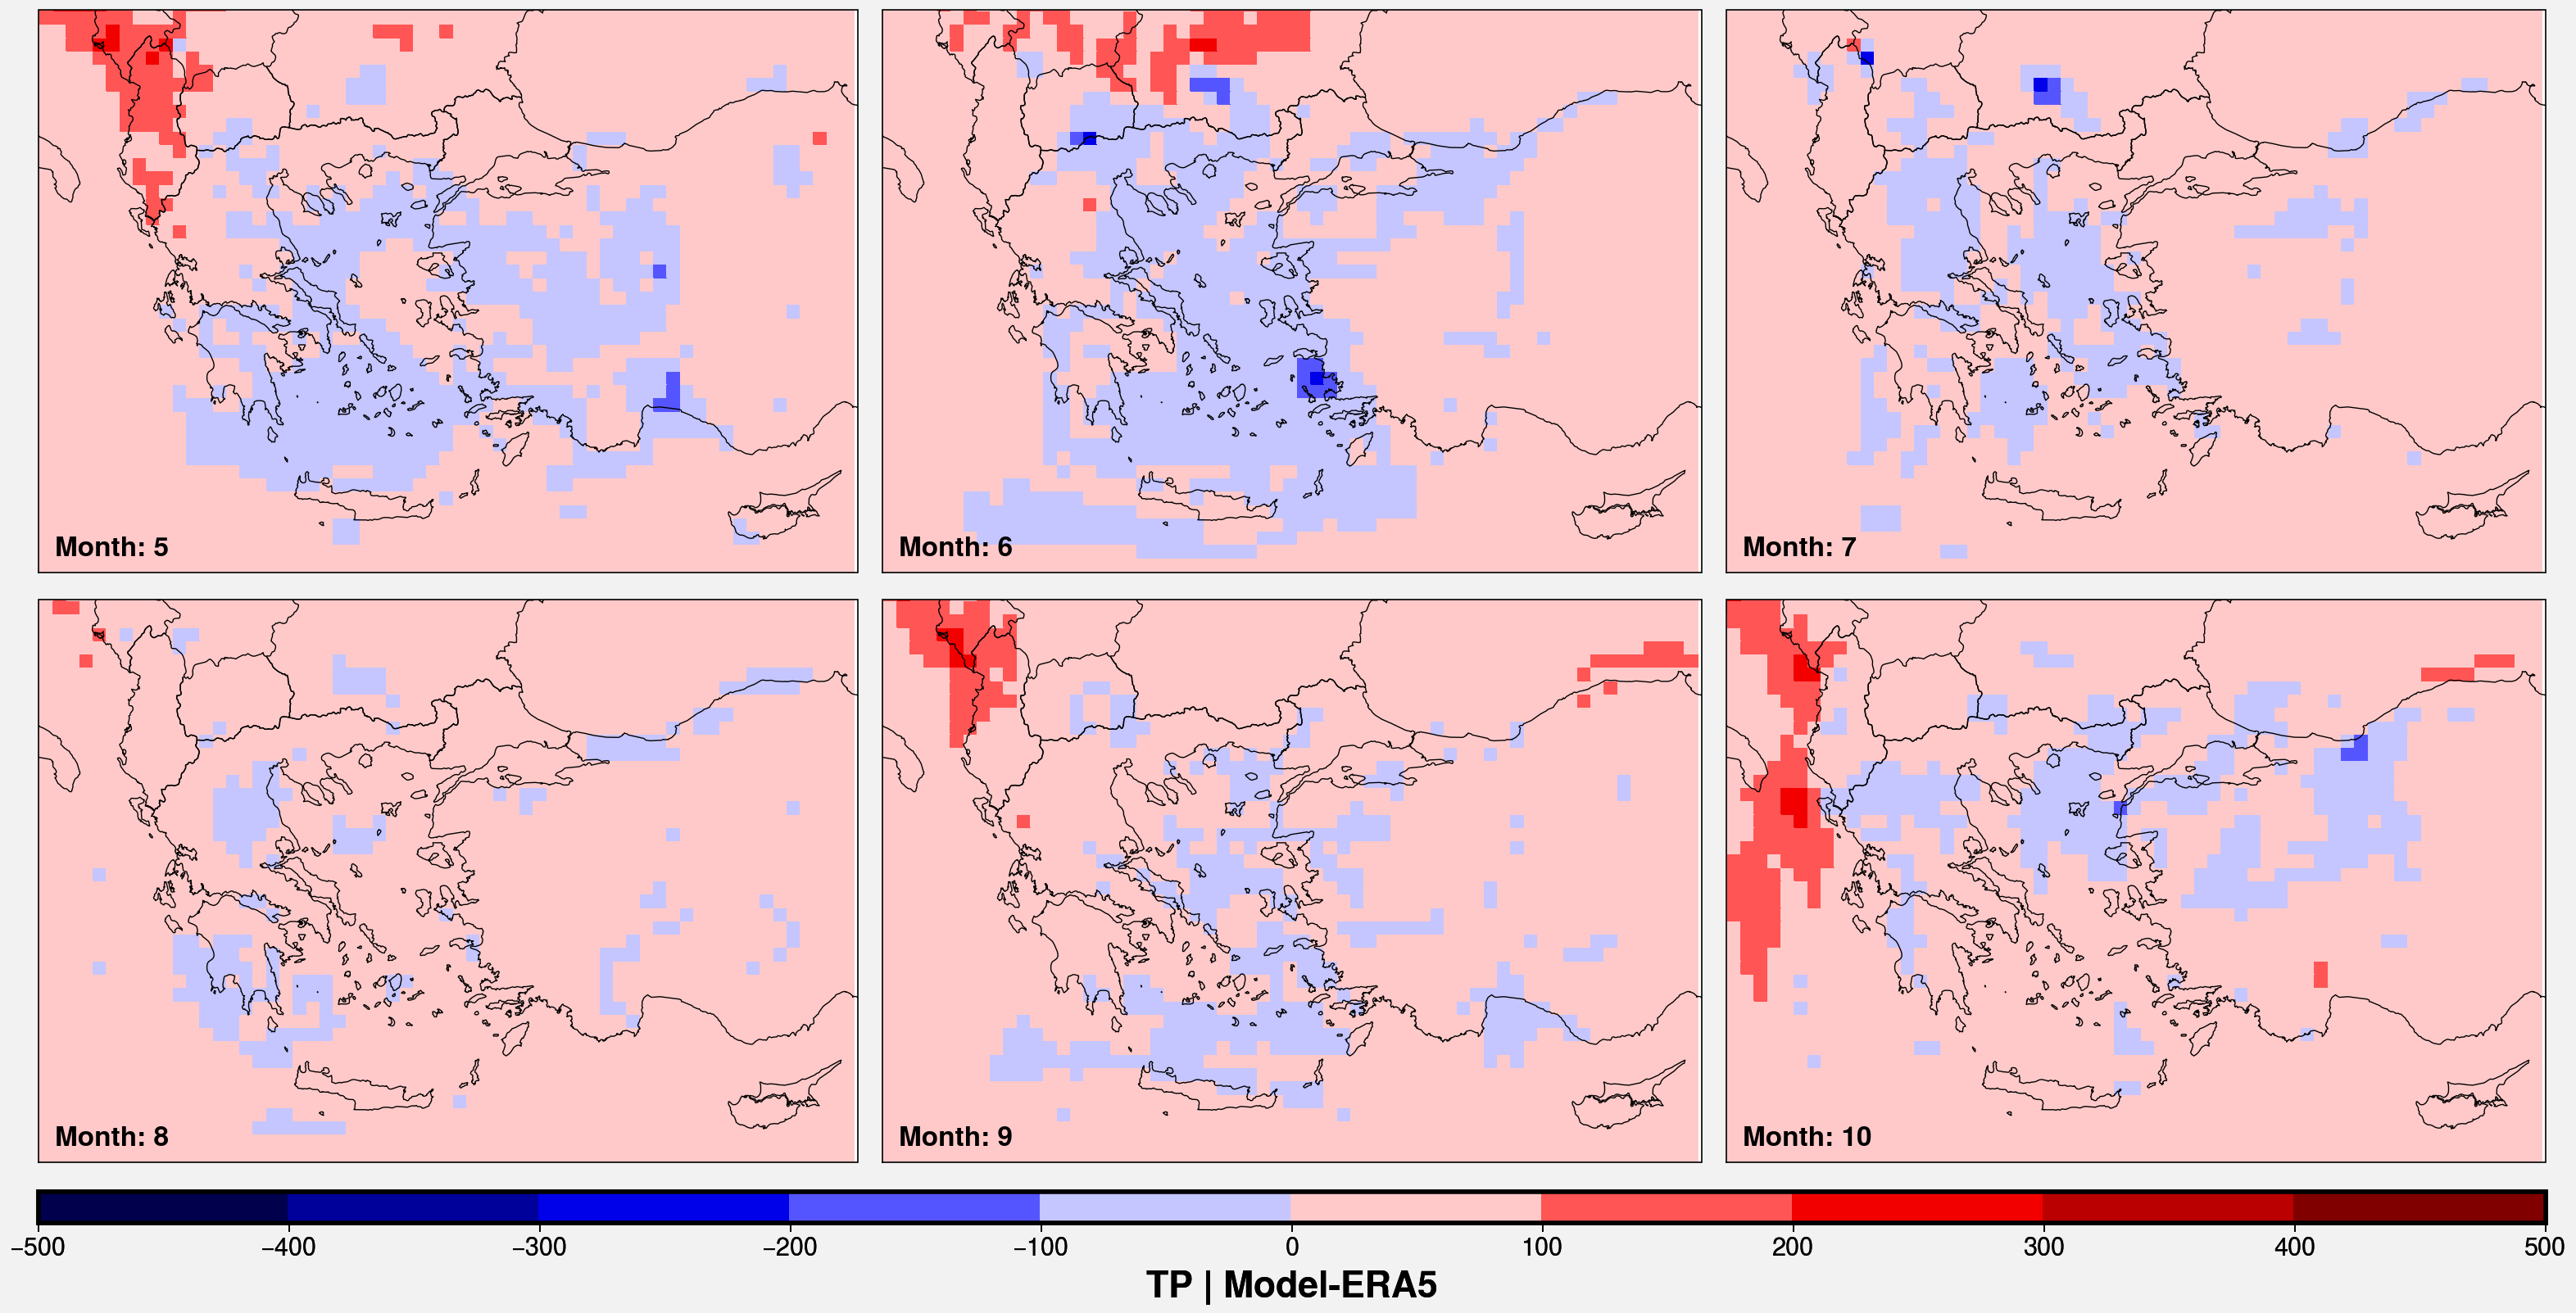

In [27]:
# Parameters to change (plot) -------------------
cmap = plt.get_cmap('seismic')
vmin = -500 # consider lower limit above
vmax = 500 # consider upper limit above
norm = BoundaryNorm(np.arange(vmin, vmax+100, 100), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax+100, 100)
# -----------------------

# data
data_df = average_bymonth_difference.sel(month=slice(5,10))

# graphic features
fig_array = [[1,2,3],
            [4,5,6],]
graphic_no = 6
method='Month'
difference_method = 'Model-ERA5'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)

### 6.2.2 Seasonal Mean Graphic

In [28]:
# seasonal means of each data
season_era5 = calculate_season_means(average_bymonth_reprojected_interp)
season_model = calculate_season_means(average_bymonth_model_interp)

# seasonal difference between data
season_difference = season_era5 - season_model

In [29]:
print(season_difference.min())
print(season_difference.max())

<xarray.DataArray ()>
array(-246.51745605)
Coordinates:
    spatial_ref   int64 0
    rotated_pole  int64 0
<xarray.DataArray ()>
array(436.14775085)
Coordinates:
    spatial_ref   int64 0
    rotated_pole  int64 0


#### **BELOW, YOU SHOULD CHECK THE PARAMETERS**

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


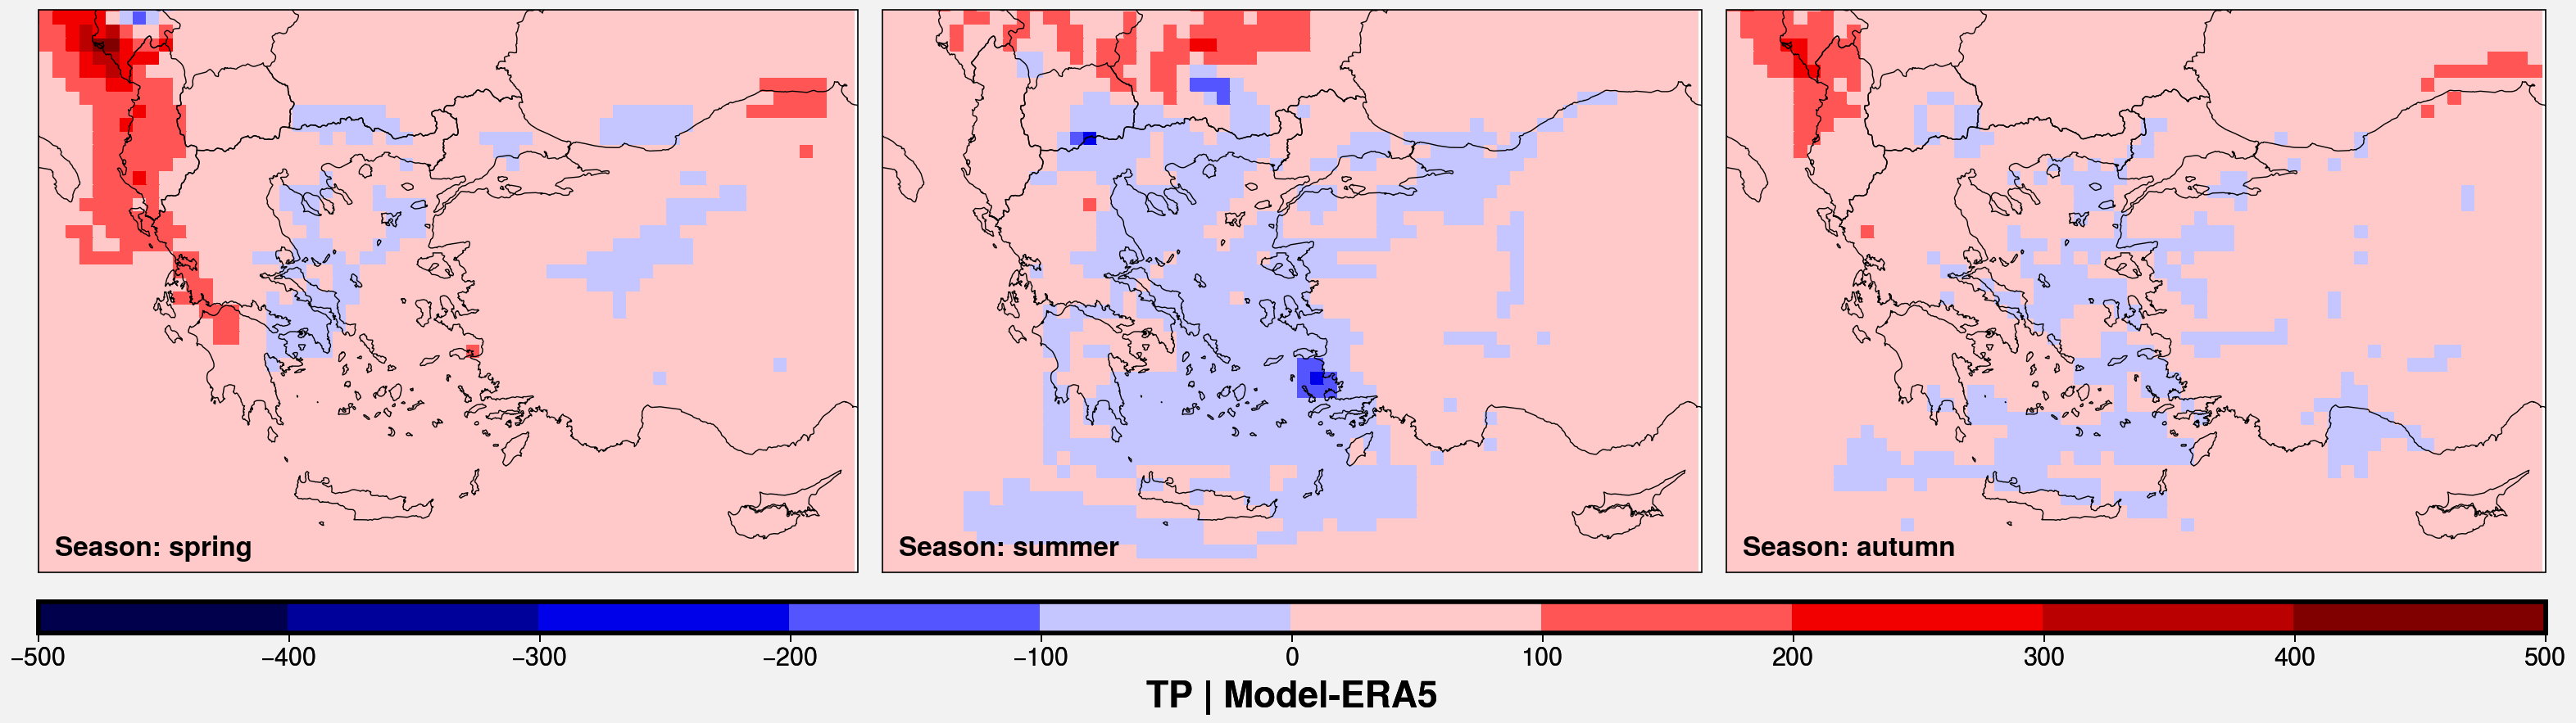

In [30]:
# Parameters to change (plot) -------------------
cmap = plt.get_cmap('seismic')
vmin = -500 # consider lower limit above
vmax = 500 # consider upper limit above
norm = BoundaryNorm(np.arange(vmin, vmax+100, 100), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax+100, 100)
# --------------------------

# data
data_df = season_difference

# graphic features
fig_array = [[1,2,3],
            ]
graphic_no = 3
method='Season'
difference_method = 'Model-ERA5'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, era5_var, model_level,
               plevel, method, difference_method, fig_array)